# 01 | Getting the list of stations

In [3]:
import datetime as dt
import polars as pl
from wetterdienst.provider.dwd.observation import DwdObservationRequest
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [4]:
# Request all stations for some parameter/period (needed to get metadata) - We can use whatever parameter, just to get the stations..
req = DwdObservationRequest(
    parameters=("daily", "precipitation_more"),
    start_date=dt.datetime(2020, 1, 1),
    end_date=dt.datetime(2020, 1, 20),
)

stations = req.all()
df = stations.df  # Polars DataFrame
# Filter stations located in Saxony
saxony_stations = df.filter(pl.col("state") == "Sachsen")
# Select only relevant columns
subset = saxony_stations.select(["station_id", "name", "latitude", "longitude"])
# Export to CSV
subset.write_csv("saxony_stations.csv")
print("Exported", subset.shape[0], "saxony_stations.csv")

Exported 380 saxony_stations.csv


## Now that we have our stations, let's just map them on Germany's map, just to see if everything is okay..

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


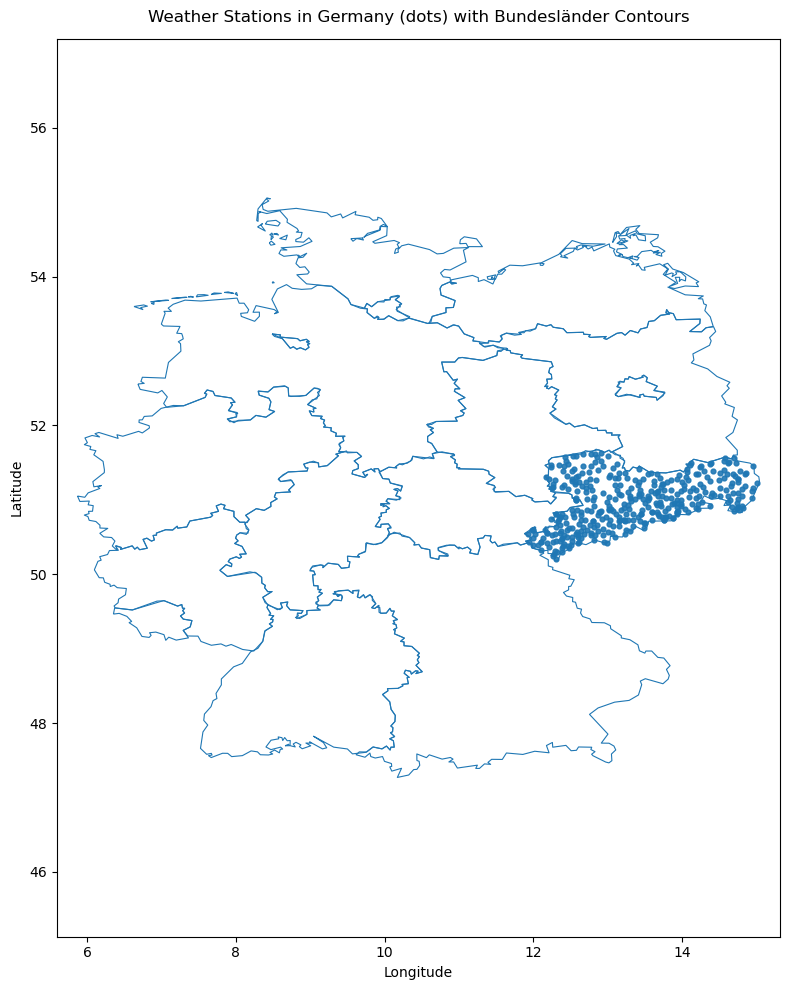

In [5]:
# Load the station CSV
csv_path = "saxony_stations.csv"  # change if needed
df = pd.read_csv(csv_path)

# Build a GeoDataFrame from lon/lat
gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326",
)

# Load Bundesländer boundaries (GeoJSON)
bundes_geojson = (
    "https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/"
    "2_bundeslaender/4_niedrig.geo.json"
)
bundes = gpd.read_file(bundes_geojson).to_crs("EPSG:4326")

# Plot
fig, ax = plt.subplots(figsize=(8, 10))

# Plot Bundesländer outlines (contours)
bundes.boundary.plot(ax=ax, linewidth=0.8)

# Plot stations as simple dots
gdf_points.plot(ax=ax, markersize=12, alpha=0.9)

# framing
ax.set_title("Weather Stations in Germany (dots) with Bundesländer Contours", pad=12)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal", adjustable="datalim")

# Zoom to Germany extent with a small padding
minx, miny, maxx, maxy = bundes.total_bounds
pad_x = (maxx - minx) * 0.03
pad_y = (maxy - miny) * 0.03
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

plt.tight_layout()
plt.show()
